# Antenna Pattern Standard 

> We used SMAP patterns as our baseline. For more information about SMAP patterns see [L1-L3 Ancilliary Products](https://nsidc.org/sites/default/files/smap_anc_l1l3l4.pdf). Specifically, the bottom of page 6.

The naming convention is
```
CIMR-OAP-BK-C1-UVv0.1.h5 
```
where
- `CIMR` is the name of the experiment (can be i.e., SMAP)
- `OAP` stands for the Original Antenna Pattern. Can also be `PAP` which means Preprocessed Antenna Pattern. The difference is that the former is the interpolation of the original pattern onto rectilinear grid. 
- `BK` stands for Backward (i.e., the Back-Half space of the pattern). Other possible value is `FR`
- `C1` is the horn name and number
- `UV` stands for $(u,v)$ grid. Alternatively, it can be `TP` which stands for $(\theta, \phi)$ grid. 
- `v0.1` is the version number 

It contains the following fields
```
/                        Group
/Gain                    Group
/Gain/G1h                Dataset {2501, 2501}
/Gain/G1v                Dataset {2501, 2501}
/Gain/G2h                Dataset {2501, 2501}
/Gain/G2v                Dataset {2501, 2501}
/Gain/G3h                Dataset {2501, 2501}
/Gain/G3v                Dataset {2501, 2501}
/Gain/G4h                Dataset {2501, 2501}
/Gain/G4v                Dataset {2501, 2501}
/Grid                    Group
/Grid/dx                 Dataset {SCALAR}
/Grid/dy                 Dataset {SCALAR}
/Grid/nx                 Dataset {SCALAR}
/Grid/ny                 Dataset {SCALAR}
/Grid/u                  Dataset {2501}
/Grid/v                  Dataset {2501}
/Grid/xcen               Dataset {SCALAR}
/Grid/xs                 Dataset {SCALAR}
/Grid/ycen               Dataset {SCALAR}
/Grid/ys                 Dataset {SCALAR}
/Version                 Dataset {SCALAR}
```
Preprocessed version hence will be: 
```
/                        Group
/Gain                    Group
/Gain/G1h                Dataset {3600, 900}
/Gain/G1v                Dataset {3600, 900}
/Gain/G2h                Dataset {3600, 900}
/Gain/G2v                Dataset {3600, 900}
/Gain/G3h                Dataset {3600, 900}
/Gain/G3v                Dataset {3600, 900}
/Gain/G4h                Dataset {3600, 900}
/Gain/G4v                Dataset {3600, 900}
/Grid                    Group
/Grid/phi                Dataset {3600}
/Grid/theta              Dataset {900}
/Version                 Dataset {SCALAR}
```

[__Note__]: To see the structure of hdf5 file use: 
```
$ h5ls -r CIMR-OAP-BK-C1-TP.h5 
```

## How to get the results below? 

The executable to convert the antenna patterns is located inside `src/cimr-grasp/cimr-grasp.py`. 

You will need to create a `AP` directory inside `dpr` and put there antenna patterns. But each pattern should get a directory for each band, i.e., if you want to run the code on L and C bands only, you will have to create the following directories (inside `/` of the repo): 
```
dpr/AP/L
dpr/AP/C
```
and put the corresponding antenna patterns inside of these directories. 

In practice, just go to S[&]T Google Drive for CIMR RGB and fetch [the archives (from here)](https://drive.google.com/drive/folders/17mhlrODuXrmlFvnhOpomt28p2WhZ3S84?usp=sharing) of patterns you want to parse and then unpack them inside `dpr/APR` and the aforementioned directories should be automatically created. 

In [9]:
import pathlib 
import re 
import glob 
import numbers 
import sys 

import numpy as np 
import scipy as sp 
import h5py 
import xarray as xr 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.tri as tri 
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Getting custom modules
# Add the root of your project to PYTHONPATH
rootpath = pb.Path('.').resolve().parents[1]
syspath = str(rootpath.joinpath("src", "cimr-grasp"))
sys.path.append(syspath) 
syspath = str(rootpath.joinpath("src"))
sys.path.append(syspath)
#print(syspath)
import grasp_io as gio
from config_file import ConfigFile
from grid_generator import GridGenerator, GRIDS
from data_ingestion import DataIngestion
from regridder_v2 import ReGridder

In [11]:
#%matplotlib notebook 

def load_hdf5_to_dict(hdf5_group):
    data_dict = {}
    for key, value in hdf5_group.items():
        if isinstance(value, h5py.Group):
            # If the value is a group, recursively call the function for the subgroup
            data_dict[key] = load_hdf5_to_dict(value)
        elif isinstance(value, h5py.Dataset):
            # If the value is a dataset, load the data into a NumPy array
            data_dict[key] = np.array(value)
        else:
            # If the value is an attribute, load it into the dictionary
            data_dict[key] = hdf5_group.attrs[key]

    return data_dict

# This is one is unnecessary I think
def reconstruct_data(array): 

    real_part = np.array([[elem[0] for elem in row] for row in array])
    imag_part = np.array([[elem[1] for elem in row] for row in array])
    
    return real_part + 1j * imag_part


def find_repo_root(start_path: pathlib.Path = None) -> pathlib.Path:
    # If no start path is provided, use the current working directory
    if start_path is None:
        start_path = pathlib.Path.cwd()
    
    # Convert to absolute path
    start_path = start_path.resolve()
    
    # Check each directory from the start path upwards to the root
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').is_dir():
            return parent
    
    raise FileNotFoundError("No .git directory found in any parent directories")

root_dir = find_repo_root()
print(f"The root of the repo is: {root_dir}")

outputdir = f"{root_dir}/output/"
if not pathlib.Path(outputdir).exists():
    pathlib.Path(outputdir).mkdir() 
    print(f"Created {outputdir}")

imgsdir = f"{root_dir}/output/imgs"
if not pathlib.Path(imgsdir).exists():
    pathlib.Path(imgsdir).mkdir() 
    print(f"Created {imgsdir}")

# Just copied from the io library 
def uv_to_tp(u,v):
    """
    Converting (u,v) into (theta,phi) and returning the grid in radians.

    According to the GRASP manual, the relations between (u, v) and (theta,
    phi) coordinates are:

    $$
    u=\sin\theta\cos\phi
    $$
    $$
    v=\sin\theta\sin\phi
    $$

    which makes up the unit vector to the field point as

    $$
    \hat{r} = \left( u, v, \sqrt{1 - u^2 - v^2} \right)
    $$

    The reverse relations then are:

    $$
    \theta=\arccos{\sqrt{1-u^2-v^2}}
    $$
    $$
    \phi = \arctan\left(\frac{v}{u}\right)
    $$

    where $\phi$ is of [-180, 180] and $\theta$ is [-90, 90] (in degrees).

    See, e.g. for different conventions:
    https://en.wikipedia.org/wiki/Spherical_coordinate_system

    Parameters:
    -----------
    u: float or ndarray
        U coordinate in director cosine coordinate system

    v: float or ndarray
        V coordinate in director cosine coordinate system

    Returns:
    --------
    theta: float or ndarray
        Theta angle value

    phi  : float or ndarray
        Phi angle value
    """

    #theta = np.degrees(np.arccos(np.sqrt(1 - u**2 - v**2)))
    #phi   = np.degrees(np.arctan2(v, u))

    theta = np.degrees(np.arccos(np.sqrt(1 - u**2 - v**2)))
    phi   = np.degrees(np.arctan2(v, u))

    # Following SMAP convention, we need values for phi to be [0, 360].
    #
    # [Note]: pcolor from matplotlib won't be able to properly output it on the
    # screen after this operation, but the arrays we get are correct
    # nevertheless.
    #phi[phi < 0] += np.rad2deg(2.0 * np.pi)
    phi[phi < 0] += np.rad2deg(2.0 * np.pi)

    return theta, phi

The root of the repo is: /run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126
Created /run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/output/
Created /run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/output/imgs


dict_keys(['Gain', 'Grid', 'Version'])
(158,) (630,)
(630, 158)


/tmp/ipykernel_17955/2773033557.py:59: RuntimeWarning: divide by zero encountered in log10
  Z_plt = 10 * np.log10(np.abs(Ghh)**2)
/tmp/ipykernel_17955/2773033557.py:64: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)
/tmp/ipykernel_17955/2773033557.py:73: RuntimeWarning: divide by zero encountered in log10
  Z_plt = 10 * np.log10(np.abs(Ghv)**2)
/tmp/ipykernel_17955/2773033557.py:80: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)


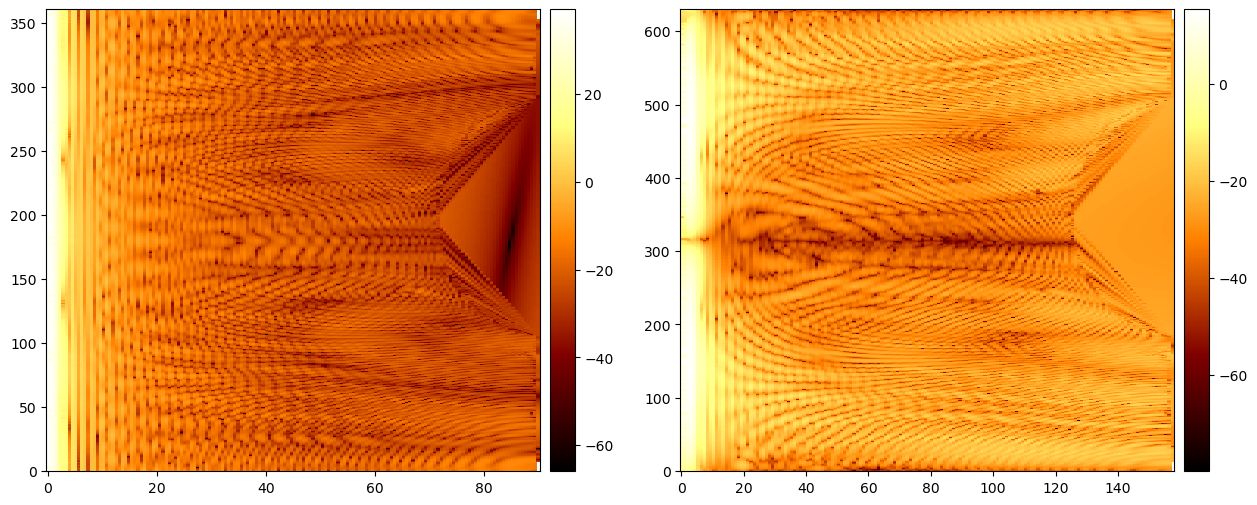

In [2]:
outfile_hdf = f"{root_dir}/output/preprocessed/CIMR-PAP-FR-L1-TPv0.3.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr = load_hdf5_to_dict(hdf5_file)

print(cimr.keys())

theta = cimr['Grid']['theta'] 
phi   = cimr['Grid']['phi'] 

print(np.shape(theta), np.shape(phi))

#theta1 = cimr['Grid']['theta'] 
#phi1   = cimr['Grid']['phi'] 

#print(theta[100:2000])

theta, phi = np.meshgrid(theta, phi)
#theta      = theta.T 
#phi        = phi.T 

Ghh = cimr['Gain']['G1h'] + 1j * cimr['Gain']['G2h'] 
Ghv = cimr['Gain']['G3h'] + 1j * cimr['Gain']['G4h'] 
Gvv = cimr['Gain']['G1v'] + 1j * cimr['Gain']['G2v']
Gvh = cimr['Gain']['G3v'] + 1j * cimr['Gain']['G4v']

print(np.shape(Ghh))

#Ghh1 = cimr['Gain']['G1h'] + 1j * cimr['Gain']['G2h'] 
#Ghv1 = cimr['Gain']['G3h'] + 1j * cimr['Gain']['G4h'] 
#Gvv1 = cimr['Gain']['G1v'] + 1j * cimr['Gain']['G2v']
#Gvh1 = cimr['Gain']['G3v'] + 1j * cimr['Gain']['G4v']

#outfile_hdf = f"{root_dir}/output/parsed/CIMR-AP-BK-L1-TPv0.2.h5" 

# Open the HDF5 file and load it into a dictionary
#with h5py.File(outfile_hdf, 'r') as hdf5_file:
#    cimr = load_hdf5_to_dict(hdf5_file)

#Ghh2 = cimr['Gain']['G1h'] + 1j * cimr['Gain']['G2h'] 
#Ghv2 = cimr['Gain']['G3h'] + 1j * cimr['Gain']['G4h'] 
#Gvv2 = cimr['Gain']['G1v'] + 1j * cimr['Gain']['G2v']
#Gvh2 = cimr['Gain']['G3v'] + 1j * cimr['Gain']['G4v']

#theta2 = cimr['Grid']['theta'] 
#phi2   = cimr['Grid']['phi'] 

#Ghh = np.concatenate((Ghh2, Ghh1), axis=0) 
#Ghv = np.concatenate((Ghv2, Ghv1), axis=0) 

#phi = np.concatenate((phi2, phi1), axis=0) 
#theta = np.concatenate((-theta2, theta1), axis=0) 

#G[0, 0] = np.abs(Gvv)**2 

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 
Z_plt = 10 * np.log10(np.abs(Ghh)**2)
pcm2 = axes[0].pcolor(theta, phi, Z_plt, shading='auto', cmap=cmap)

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

#pcm2 = axes[0].imshow(theta)

#pcm2 = axes[1].imshow(phi)

#pcm2 = axes[0].pcolor(Z_plt, shading='auto', cmap=cmap)
#axes[0].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_x|^2 + |C_x|^2)$')

Z_plt = 10 * np.log10(np.abs(Ghv)**2)
pcm2 = axes[1].pcolor(theta, phi, Z_plt, shading='auto', cmap=cmap)
pcm2 = axes[1].pcolor(Z_plt, shading='auto', cmap=cmap)

# Create a shared color bar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

plt.savefig(f'{imgsdir}/CIMR-PAP-FR-L1-TPv0.3.png', dpi=300) 
plt.show()

dict_keys(['Gain', 'Grid', 'Version'])
(1501, 1501)
[[16.42994019 16.48636062 16.54298347 ... 30.26791745 30.34916072
  30.43050813]
 [16.48636062 16.54261029 16.59906301 ... 30.30311932 30.38430652
  30.46559825]
 [16.54298347 16.59906301 16.65534623 ... 30.33853049 30.41966149
  30.50089741]
 ...
 [30.26791745 30.30311932 30.33853049 ... 40.8673114  40.93883367
  41.01053618]
 [30.34916072 30.38430652 30.41966149 ... 40.93883367 41.01033047
  41.0820079 ]
 [30.43050813 30.46559825 30.50089741 ... 41.01053618 41.0820079
  41.15366065]]


/tmp/ipykernel_17955/1442079082.py:121: RuntimeWarning: invalid value encountered in sqrt
  theta = np.degrees(np.arccos(np.sqrt(1 - u**2 - v**2)))
/tmp/ipykernel_17955/4059932014.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)
/tmp/ipykernel_17955/4059932014.py:79: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm2, cax=cax)


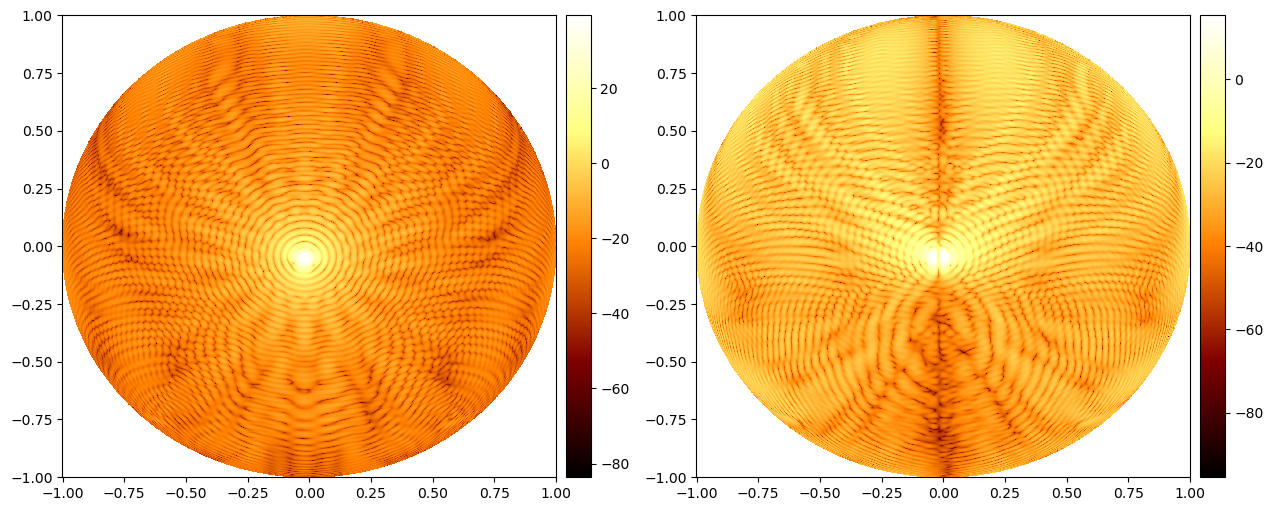

In [3]:
outfile_hdf = f"{root_dir}/output/parsed/CIMR-OAP-FR-L1-UVv0.3.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr = load_hdf5_to_dict(hdf5_file)

print(cimr.keys())

Ghh = cimr['Gain']['G1h'] + 1j * cimr['Gain']['G2h'] 
Ghv = cimr['Gain']['G3h'] + 1j * cimr['Gain']['G4h'] 
Gvv = cimr['Gain']['G1v'] + 1j * cimr['Gain']['G2v']
Gvh = cimr['Gain']['G3v'] + 1j * cimr['Gain']['G4v']

u = cimr['Grid']['u']
v = cimr['Grid']['v']

#xcen = cimr['Grid']['xcen']
#ycen = cimr['Grid']['ycen']

#xs = cimr['Grid']['xs']
#ys = cimr['Grid']['ys']

#dx = cimr['Grid']['dx']
#dy = cimr['Grid']['dy']

#nx = cimr['Grid']['nx']
#ny = cimr['Grid']['ny']

#u0 = xcen + xs
#u1 = u0 + dx * (nx - 1)
#v0 = ycen + ys
#v1 = v0 + dy * (ny - 1)

#u_grid, v_grid = np.mgrid[u0:(u1 + dx):dx, v0:(v1 + dy):dy]

u_grid, v_grid = np.meshgrid(u,v)

theta_grid, phi_grid = uv_to_tp(u_grid.T, v_grid.T)

print(theta_grid.shape) 

print(theta_grid[900:1100,900:1100])

#u,v  = np.meshgrid(u, v)
#u, v = u.T, v.T

#G[0, 0] = np.abs(Gvv)**2 
cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 

Z_plt = 10 * np.log10(np.abs(Ghh)**2)
pcm2 = axes[0].pcolor(u, v, Z_plt, shading='auto', cmap=cmap)
#axes[0].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_x|^2 + |C_x|^2)$')

divider = make_axes_locatable(axes[0]) 
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

# Plot the center lines
#axes[0].axhline(y=v_cen, color='black', linestyle='--', label=f'v = {v_cen}')
#axes[0].axvline(x=u_cen, color='black', linestyle='--', label=f'u = {u_cen}')

#axes[0].axhline(y=0, color='red', linestyle='--', label=f'v = {v_cen}')
#axes[0].axvline(x=0, color='red', linestyle='--', label=f'u = {u_cen}')

Z_plt = 10 * np.log10(np.abs(Ghv)**2)
pcm2 = axes[1].pcolor(u, v, Z_plt, shading='auto', cmap=cmap)

# Plot the center lines
#axes[1].axhline(y=v_cen, color='black', linestyle='--', label=f'v = {v_cen}')
#axes[1].axvline(x=u_cen, color='black', linestyle='--', label=f'u = {u_cen}')

#axes[1].axhline(y=0, color='red', linestyle='--', label=f'v = {v_cen}')
#axes[1].axvline(x=0, color='red', linestyle='--', label=f'u = {u_cen}')

# Create a shared color bar
divider = make_axes_locatable(axes[1]) 
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm2, cax=cax)

# -------------------------------------------------------------------------
#Z_plt = 10 * np.log10(np.abs(Ghh)**2)
#pcm2 = axes[1][0].pcolormesh(theta_grid, phi_grid, Z_plt, shading='auto', cmap=cmap)
#axes[0].set_title(r'Band: C, Horn: 1, Half-Space: Both $(|R_x|^2 + |C_x|^2)$')

#divider = make_axes_locatable(axes[1][0]) 
#cax = divider.append_axes("right", size="5%", pad=0.1)
#cbar = fig.colorbar(pcm2, cax=cax)



plt.savefig(f'{imgsdir}/CIMR-OAP-FR-L1-UVv0.3.png', dpi=300) 
plt.show()

In [1]:
vers = "0.6.0"
outfile_hdf = f"{root_dir}/output/parsed/v{vers}/CIMR-OAP-FR-C1-UVv{vers}.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr_orig = load_hdf5_to_dict(hdf5_file)

Ghh_orig = cimr_orig['Gain']['G1h'] + 1j * cimr_orig['Gain']['G2h'] 
Ghh_orig = Ghh_orig.ravel() 
#print(Ghh_orig)
#exit() 
temperature_orig = np.log10(np.abs(Ghh_orig)**2)
u = cimr_orig['Grid']['u']
v = cimr_orig['Grid']['v']
u_orig, v_orig = np.meshgrid(u,v)
u_orig, v_orig = np.ravel(u_orig), np.ravel(v_orig)
#print(u_orig.shape, v_orig.shape, Ghh_orig.shape) 
#exit() 
triang_orig = tri.Triangulation(u_orig, v_orig)

outfile_hdf = f"{root_dir}/output/preprocessed/v{vers}/CIMR-PAP-FR-C1-TPv{vers}.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr_down = load_hdf5_to_dict(hdf5_file)

u_down = cimr_down['Grid']['x']
v_down = cimr_down['Grid']['y']
Ghh_down = cimr_down['Gain']['G1h'] + 1j * cimr_down['Gain']['G2h'] 
print(Ghh_down) 
temperature_down = np.log10(np.abs(Ghh_down)**2)

triang_down = tri.Triangulation(u_down, v_down)

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(3,1, figsize=(15, 30)) 


im = axes[0].tripcolor(triang_orig, temperature_orig, cmap='viridis')
im = axes[1].tripcolor(triang_down, temperature_down, cmap='viridis')


outfile_hdf = f"{root_dir}/output/preprocessed/v{vers}/CIMR-PAP-FR-C1-TPv{vers}.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr_down = load_hdf5_to_dict(hdf5_file)

u_down = cimr_down['Grid']['x']
v_down = cimr_down['Grid']['y']                                    
Ghh_down = cimr_down['Gain']['G1h'] + 1j * cimr_down['Gain']['G2h'] 
print(Ghh_down) 
temperature_down = np.log10(np.abs(Ghh_down)**2)

triang_down = tri.Triangulation(u_down, v_down)

im = axes[2].tripcolor(triang_down, temperature_down, cmap='viridis')
#pcm2 = axes[1].pcolor(u, v, temperature_down, shading='auto', cmap=cmap)
#im = axes[1].tripcolor(triang_chunk, temp_down, cmap='viridis')

NameError: name 'root_dir' is not defined

In [19]:
vers = "0.6.0"
outfile_hdf = f"{root_dir}/output/parsed/v{vers}/CIMR-OAP-FR-C1-UVv{vers}.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr_orig = load_hdf5_to_dict(hdf5_file)

Ghh_orig = cimr_orig['Gain']['G1h'] + 1j * cimr_orig['Gain']['G2h'] 
Ghh_orig = Ghh_orig.ravel() 
#print(Ghh_orig)
#exit() 
temperature_orig = np.log10(np.abs(Ghh_orig)**2)
u = cimr_orig['Grid']['u']
v = cimr_orig['Grid']['v']
u_orig, v_orig = np.meshgrid(u,v)
u_orig, v_orig = np.ravel(u_orig), np.ravel(v_orig)
#print(u_orig.shape, v_orig.shape, Ghh_orig.shape) 
#exit() 
triang_orig = tri.Triangulation(u_orig, v_orig)

outfile_hdf = f"{root_dir}/output/preprocessed/v{vers}/CIMR-PAP-FR-C1-TPv{vers}.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr_down = load_hdf5_to_dict(hdf5_file)

u_down = cimr_down['Grid']['x']
v_down = cimr_down['Grid']['y']
Ghh_down = cimr_down['Gain']['G1h'] + 1j * cimr_down['Gain']['G2h'] 
print(Ghh_down) 
temperature_down = np.log10(np.abs(Ghh_down)**2)

triang_down = tri.Triangulation(u_down, v_down)

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(2,1, figsize=(15, 15)) 


im = axes[0].tripcolor(triang_orig, temperature_orig, cmap='viridis')
im = axes[1].tripcolor(triang_down, temperature_down, cmap='viridis')


#outfile_hdf = f"{root_dir}/output/preprocessed/v{vers}/CIMR-PAP-FR-C1-TPv{vers}.h5" 

# Open the HDF5 file and load it into a dictionary
#with h5py.File(outfile_hdf, 'r') as hdf5_file:
#    cimr_down = load_hdf5_to_dict(hdf5_file)

#u_down = cimr_down['Grid']['x']
#v_down = cimr_down['Grid']['y']                                    
#Ghh_down = cimr_down['Gain']['G1h'] + 1j * cimr_down['Gain']['G2h'] 
#print(Ghh_down) 
#temperature_down = np.log10(np.abs(Ghh_down)**2)

#triang_down = tri.Triangulation(u_down, v_down)

#im = axes[2].tripcolor(triang_down, temperature_down, cmap='viridis')
#pcm2 = axes[1].pcolor(u, v, temperature_down, shading='auto', cmap=cmap)
#im = axes[1].tripcolor(triang_chunk, temp_down, cmap='viridis')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/run/media/eva-v3/seagate_small/Maks/CurrProjects/SaT/CIMR-RGB/code/cimr-126/output/parsed/v0.6.1/CIMR-OAP-FR-C1-UVv0.6.1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [38]:
vers = "0.6.1"
#outfile_hdf = f"{root_dir}/output/parsed/v{vers}/CIMR-OAP-FR-L1-UVv{vers}.h5" 

# Open the HDF5 file and load it into a dictionary
#with h5py.File(outfile_hdf, 'r') as hdf5_file:
#    cimr_orig = load_hdf5_to_dict(hdf5_file)

#Ghh_orig = cimr_orig['Gain']['G1h'] + 1j * cimr_orig['Gain']['G2h'] 
#print(Ghh_orig[~np.isnan(Ghh_orig)]) 
#print(Ghh_orig.shape)

outfile_hdf = f"{root_dir}/output/preprocessed/v{vers}/CIMR-PAP-FR-L1-TPv{vers}.h5" 

# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr_down = load_hdf5_to_dict(hdf5_file)

Ghh_down = cimr_down['Gain']['G1h'] + 1j * cimr_down['Gain']['G2h'] 
#Ghh_down = Ghh_down.reshape(3600, 900)
print(Ghh_down.shape) 

theta = cimr_down['Grid']['theta']
phi   = cimr_down['Grid']['phi']
theta_down, phi_down = np.meshgrid(theta, phi)

x = cimr_down['Grid']['x'].reshape(3600, 900)
y = cimr_down['Grid']['y'].reshape(3600, 900)
#theta_down, phi_down = np.meshgrid(theta, phi)

#plt.imshow(np.real(Ghh_down)) 

cmap = plt.get_cmap('afmhot')
fig, axes = plt.subplots(1, 2, figsize=(15,6)) 

Z_plt = 10 * np.log10(np.abs(Ghh_down)**2)
pcm2 = axes[0].pcolor(theta_down, phi_down, Z_plt, shading='auto', cmap=cmap)
pcm2 = axes[1].pcolor(x, y, Z_plt, shading='auto', cmap=cmap)
#pcm2 = axes[2].imshow(Z_plt)

plt.show()

(3600, 900)


/tmp/ipykernel_590314/663746975.py:37: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pcm2 = axes[1].pcolor(x, y, Z_plt, shading='auto', cmap=cmap)


In [42]:
outfile_hdf = f"{root_dir}/output/preprocessed/v{vers}/CIMR-PAP-FR-L1-TPv{vers}.h5" 
# Open the HDF5 file and load it into a dictionary
with h5py.File(outfile_hdf, 'r') as hdf5_file:
    cimr_down = load_hdf5_to_dict(hdf5_file)

Ghh_down = np.ravel(cimr_down['Gain']['G1h'] + 1j * cimr_down['Gain']['G2h']) 

x = cimr_down['Grid']['x']#.reshape(3600, 900)
y = cimr_down['Grid']['y']#.reshape(3600, 900)

temperature_down = np.log10(np.abs(Ghh_down)**2)

triang_down = tri.Triangulation(x, y)

fig, axes = plt.subplots(1, 2, figsize=(15, 6)) 
im = axes[0].tripcolor(triang_down, temperature_down, cmap='viridis')

triang_down = tri.Triangulation(theta_down.ravel(), phi_down.ravel())
im = axes[1].tripcolor(triang_down, temperature_down, cmap='viridis')

plt.show() 